In [37]:
import os
import sys
sys.path.append('../src/')
import glob
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 101)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import cca_functions

# configurations
- follow the file selection dialog:
    - select microscopy folder in first step
    - select positions of the selected folder in second step
- repeat to add more positions to the analysis
- positions selected within one iteration of the dialog will be pooled together in the following analyses

In [2]:
data_dirs, positions = cca_functions.configuration_dialog()
file_names = [os.path.split(path)[-1] for path in data_dirs]
image_folders = [[os.path.join(data_dir, pos_str, 'Images') for pos_str in pos_list] for pos_list, data_dir in zip(positions, data_dirs)]
# determine available channels based on first(!) position.
# Warn user if one or more of the channels are not available for some positions
first_pos_files = os.listdir(os.path.join(data_dirs[0], positions[0][0], 'Images'))
channels, warn = cca_functions.find_available_channels(first_pos_files)

# load data and perform all needed calculations on image data

In [3]:
overall_df = cca_functions.calculate_downstream_data(
    file_names,
    image_folders,
    positions, 
    channels, 
    force_recalculation=True)

Load files for MIA_KC_test_files, Position_2...


  0%|▏                                        | 1/241 [00:00<00:32,  7.32it/s]

Number of cells in position: 18
Number of annotated frames in position: 241
Calculate regionprops on each frame based on Segmentation...


  0%|                                                  | 0/18 [00:00<?, ?it/s]

Calculate mean signal strength for every channel and cell...


100%|█████████████████████████████████████████| 18/18 [00:01<00:00, 12.93it/s]


Saving calculated data for next time...
Load files for MIA_KC_test_files, Position_3...


  5%|█▊                                     | 11/241 [00:00<00:02, 108.80it/s]

Number of cells in position: 28
Number of annotated frames in position: 241
Calculate regionprops on each frame based on Segmentation...


100%|███████████████████████████████████████| 241/241 [00:05<00:00, 43.21it/s]


Calculate mean signal strength for every channel and cell...


100%|█████████████████████████████████████████| 28/28 [00:02<00:00, 12.67it/s]


Saving calculated data for next time...
Load files for MIA_KC_test_files, Position_4...


  2%|█                                        | 6/241 [00:00<00:04, 52.42it/s]

Number of cells in position: 54
Number of annotated frames in position: 241
Calculate regionprops on each frame based on Segmentation...


100%|███████████████████████████████████████| 241/241 [00:09<00:00, 26.40it/s]


Calculate mean signal strength for every channel and cell...


100%|█████████████████████████████████████████| 54/54 [00:06<00:00,  8.60it/s]


Saving calculated data for next time...
Load files for MIA_KC_test_files, Position_5...


  6%|██▍                                    | 13/208 [00:00<00:01, 120.70it/s]

Number of cells in position: 42
Number of annotated frames in position: 208
Calculate regionprops on each frame based on Segmentation...


100%|███████████████████████████████████████| 208/208 [00:07<00:00, 28.21it/s]


Calculate mean signal strength for every channel and cell...


100%|█████████████████████████████████████████| 42/42 [00:04<00:00, 10.19it/s]


Saving calculated data for next time...
Load files for MIA_KC_test_files_flu_control, Position_1...


  4%|█▌                                       | 9/241 [00:00<00:02, 86.04it/s]

Number of cells in position: 65
Number of annotated frames in position: 241
Calculate regionprops on each frame based on Segmentation...


100%|███████████████████████████████████████| 241/241 [00:11<00:00, 21.73it/s]


Calculate mean signal strength for every channel and cell...


100%|█████████████████████████████████████████| 65/65 [00:06<00:00, 10.46it/s]


Saving calculated data for next time...
Load files for MIA_KC_test_files_flu_control, Position_3...


  6%|██▎                                    | 14/239 [00:00<00:01, 131.86it/s]

Number of cells in position: 36
Number of annotated frames in position: 239
Calculate regionprops on each frame based on Segmentation...


  0%|                                                  | 0/36 [00:00<?, ?it/s]

Calculate mean signal strength for every channel and cell...


100%|█████████████████████████████████████████| 36/36 [00:02<00:00, 13.37it/s]


Saving calculated data for next time...


In [4]:
overall_df.head()

,frame_i,Cell_ID,is_cell_dead,is_cell_excluded,x_centroid,y_centroid,editIDclicked_x,editIDclicked_y,editIDnewID,cell_cycle_stage,...,file,selection_subset,position,directory,mCitrine_corrected_amount,mCitrine_corrected_concentration,phase_contr_corrected_amount,phase_contr_corrected_concentration,daughter_area,daughter_volume
0,0,1,False,False,135,67,NaN,NaN,-1,S,...,MIA_KC_test_files,0,Position_2,C:/Users/mairhoermann/Documents/phd-code/Yeast...,505469.0,4198.605,81166.0,674.194,74.0,5.308
1,0,2,False,False,152,61,NaN,NaN,-1,S,...,MIA_KC_test_files,0,Position_2,C:/Users/mairhoermann/Documents/phd-code/Yeast...,1501.0,282.796,0.0,0.000,0.0,0.000
2,1,1,False,False,135,66,NaN,NaN,-1,S,...,MIA_KC_test_files,0,Position_2,C:/Users/mairhoermann/Documents/phd-code/Yeast...,518845.0,4246.823,94391.0,772.604,75.0,5.335
3,1,2,False,False,152,60,NaN,NaN,-1,S,...,MIA_KC_test_files,0,Position_2,C:/Users/mairhoermann/Documents/phd-code/Yeast...,2049.0,384.103,0.0,0.000,0.0,0.000
4,2,1,False,False,135,66,NaN,NaN,-1,S,...,MIA_KC_test_files,0,Position_2,C:/Users/mairhoermann/Documents/phd-code/Yeast...,531606.0,4070.439,117428.0,899.131,69.0,4.699


In [26]:
# build dataframe grouped by phases
phase_grouped = overall_df.sort_values(
    'frame_i'
).groupby(
    ['Cell_ID', 'generation_num', 'cell_cycle_stage', 'position', 'file']
).agg(
    growth_in_phase=('area', lambda x: x.iloc[-1]-x.iloc[0]),
    volume_growth_in_phase=('cell_vol_fl', lambda x: x.iloc[-1]-x.iloc[0]),
    area_at_beginning=('area', lambda x: x.iloc[0]),
    volume_at_beginning=('cell_vol_fl', lambda x: x.iloc[0]),
    daughter_area_growth=('daughter_area', lambda x: x.iloc[-1]-x.iloc[0]),
    daughter_volume_growth=('daughter_volume', lambda x: x.iloc[-1]-x.iloc[0]),
    phase_length=('frame_i', lambda x: max(x)-min(x)),
    phase_begin = ('frame_i', min),
    phase_end = ('frame_i', max),
    max_frame_pos = ('max_frame_pos', 'first'),
    selection_subset = ('selection_subset', 'first'),
    cell_max_t = ('max_t', 'first'),
    mCitrine_at_beginning = ('mCitrine_corrected_amount', 'first'),
    mCitrine_mean_at_beginning = ('mCitrine_corrected_mean', 'first'),
    mCitrine_concentration_at_beginning = ('mCitrine_corrected_concentration', 'first')
).reset_index()

# detect incomplete cell cycle stages and incomplete cell cycles
temp = np.logical_or(
    phase_grouped.phase_begin == 0,
    phase_grouped.phase_end == phase_grouped.max_frame_pos
)
incomplete_phase_indices = np.logical_or(
    temp,
    phase_grouped.phase_end == phase_grouped.cell_max_t
)
no_of_phases_per_cycle = phase_grouped.groupby(
    ['Cell_ID', 'generation_num', 'position', 'file']
)['cell_cycle_stage'].transform('count')
incomplete_cycle_indices = no_of_phases_per_cycle < 2
phase_grouped['incomplete_phase'] = incomplete_phase_indices.astype(int)
phase_grouped['incomplete_cycle'] = incomplete_cycle_indices.astype(int)
phase_grouped['all_complete'] = np.logical_and(~incomplete_phase_indices, ~incomplete_cycle_indices).astype(int)

In [27]:
phase_grouped.sort_values(['file', 'position', 'Cell_ID', 'generation_num']).head(15)

,Cell_ID,generation_num,cell_cycle_stage,position,file,growth_in_phase,volume_growth_in_phase,area_at_beginning,volume_at_beginning,daughter_area_growth,...,phase_end,max_frame_pos,selection_subset,cell_max_t,mCitrine_at_beginning,mCitrine_mean_at_beginning,mCitrine_concentration_at_beginning,incomplete_phase,incomplete_cycle,all_complete
6,1,2,S,Position_2,MIA_KC_test_files,22,6.044,603,120.390,266.0,...,25,240,0,240,505469.0,838.257,4198.605,1,1,0
12,1,3,G1,Position_2,MIA_KC_test_files,129,45.719,628,128.097,NaN,...,40,240,0,240,348895.0,555.565,2723.671,0,0,1
18,1,3,S,Position_2,MIA_KC_test_files,7,2.770,765,177.337,365.0,...,72,240,0,240,362238.0,473.514,2042.649,0,0,1
24,1,4,G1,Position_2,MIA_KC_test_files,-2,-0.643,784,181.898,12.0,...,79,240,0,240,311457.0,397.267,1712.258,0,0,1
30,1,4,S,Position_2,MIA_KC_test_files,-102,-31.147,789,182.997,409.0,...,107,240,0,240,351093.0,444.985,1918.569,0,0,1
36,1,5,G1,Position_2,MIA_KC_test_files,-5,0.184,742,169.720,-5.0,...,114,240,0,240,288783.0,389.195,1701.528,0,0,1
42,1,5,S,Position_2,MIA_KC_test_files,22,6.683,726,165.893,425.0,...,143,240,0,240,283158.0,390.025,1706.875,0,0,1
48,1,6,G1,Position_2,MIA_KC_test_files,22,6.069,774,178.530,NaN,...,155,240,0,240,247022.0,319.150,1383.645,0,0,1
54,1,6,S,Position_2,MIA_KC_test_files,-53,-15.474,790,183.533,640.0,...,198,240,0,240,284142.0,359.673,1548.178,0,0,1
59,1,7,G1,Position_2,MIA_KC_test_files,41,13.889,736,166.649,85.0,...,215,240,0,240,225767.0,306.749,1354.749,0,0,1


# generate plots / analyses on obtained data

## (Volume) growth in G1 vs. mother+daughter growth in S (1st generation)

In [11]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
complete_cc_data = phase_grouped[phase_grouped.all_complete==1]
s_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="S"]
g1_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="G1"]
plot_data2 = g1_data.merge(s_data, on=['Cell_ID', 'generation_num', 'position'], how='inner')
plot_data2 = plot_data2[plot_data2.generation_num==1]
plot_data2['combined_motherbud_growth'] = plot_data2['growth_in_phase_y'] + plot_data2['daughter_area_growth_y']
plot_data2['combined_motherbud_vol_growth'] = plot_data2['volume_growth_in_phase_y'] + plot_data2['daughter_volume_growth_y']

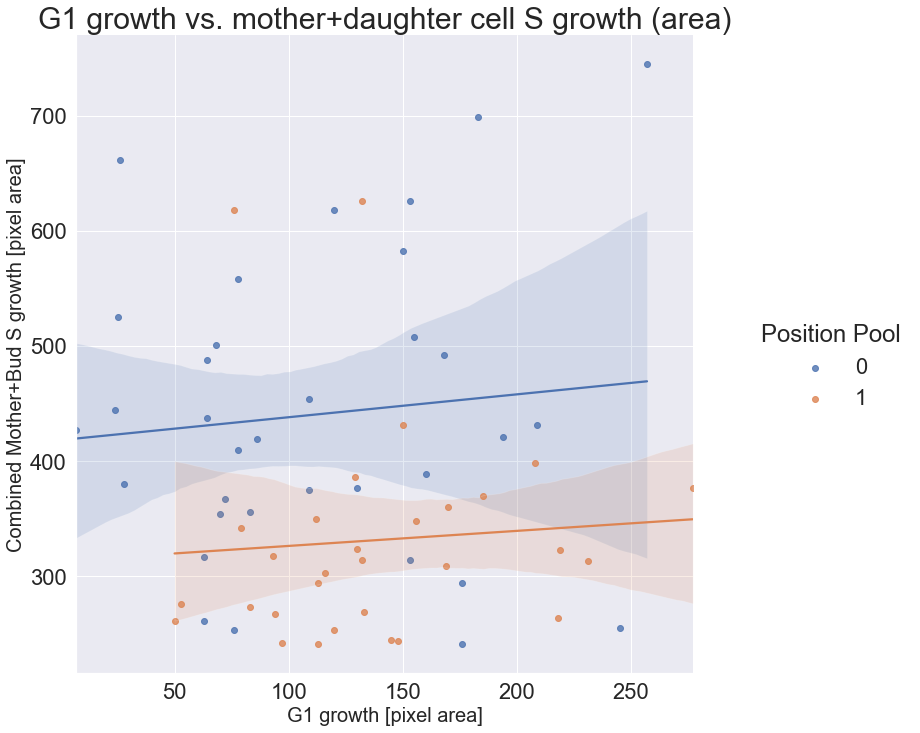

In [13]:
sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="growth_in_phase_x", y="combined_motherbud_growth", data=plot_data2,
    hue="selection_subset_x", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("Combined Mother+Bud S growth [pixel area]", fontsize=20)
ax.set_xlabel("G1 growth [pixel area]", fontsize=20)
ax.set_title("G1 growth vs. mother+daughter cell S growth (area)", fontsize=30)
plt.show()

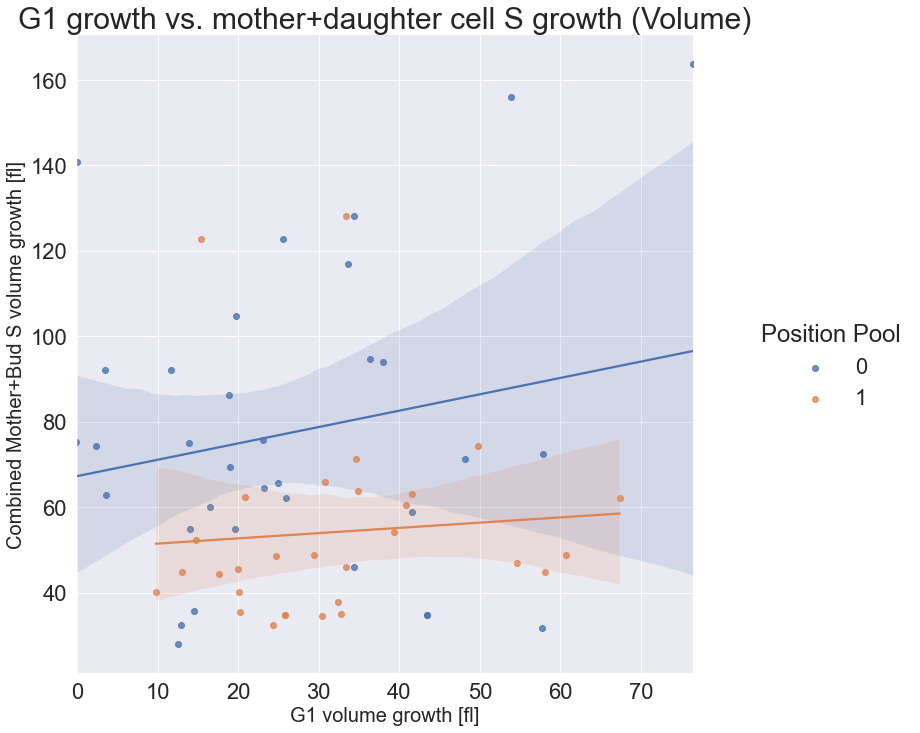

In [15]:
sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="volume_growth_in_phase_x", y="combined_motherbud_vol_growth", data=plot_data2,
    hue="selection_subset_x", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("Combined Mother+Bud S volume growth [fl]", fontsize=20)
ax.set_xlabel("G1 volume growth [fl]", fontsize=20)
ax.set_title("G1 growth vs. mother+daughter cell S growth (Volume)", fontsize=30)
plt.show()

## Area and Volume at birth vs. G1 duration (1st generation)

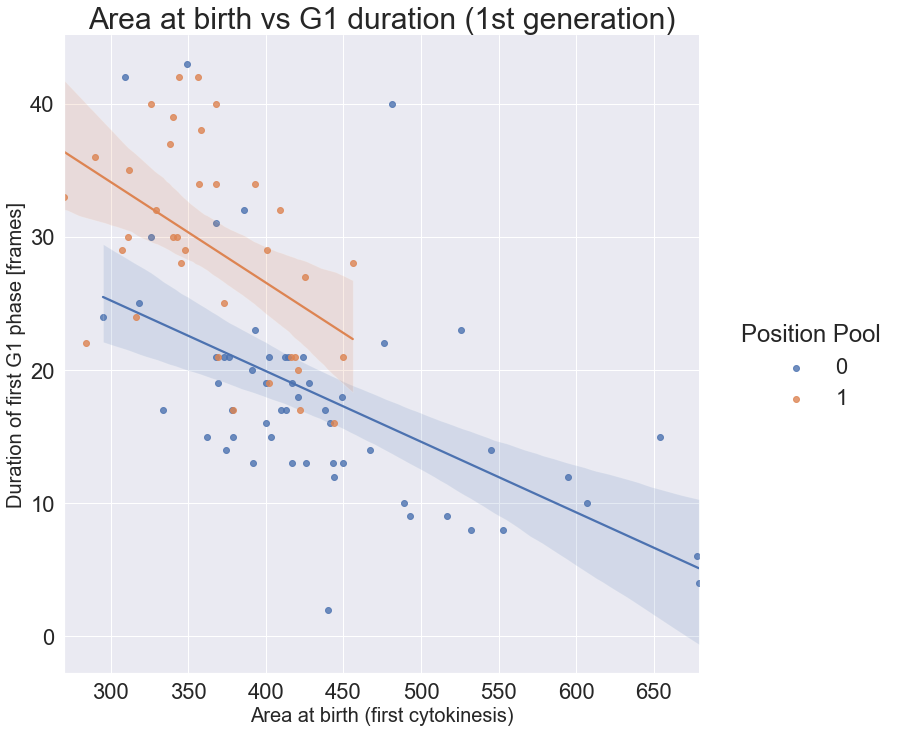

In [22]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
plot_data3 = phase_grouped[phase_grouped.cell_cycle_stage=="G1"]
plot_data3 = plot_data3[plot_data3.incomplete_phase==0]
plot_data3 = plot_data3[plot_data3.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="area_at_beginning", y="phase_length", data=plot_data3,
    hue="selection_subset", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("Duration of first G1 phase [frames]", fontsize=20)
ax.set_xlabel("Area at birth (first cytokinesis)", fontsize=20)
ax.set_title("Area at birth vs G1 duration (1st generation)", fontsize=30)
plt.show()

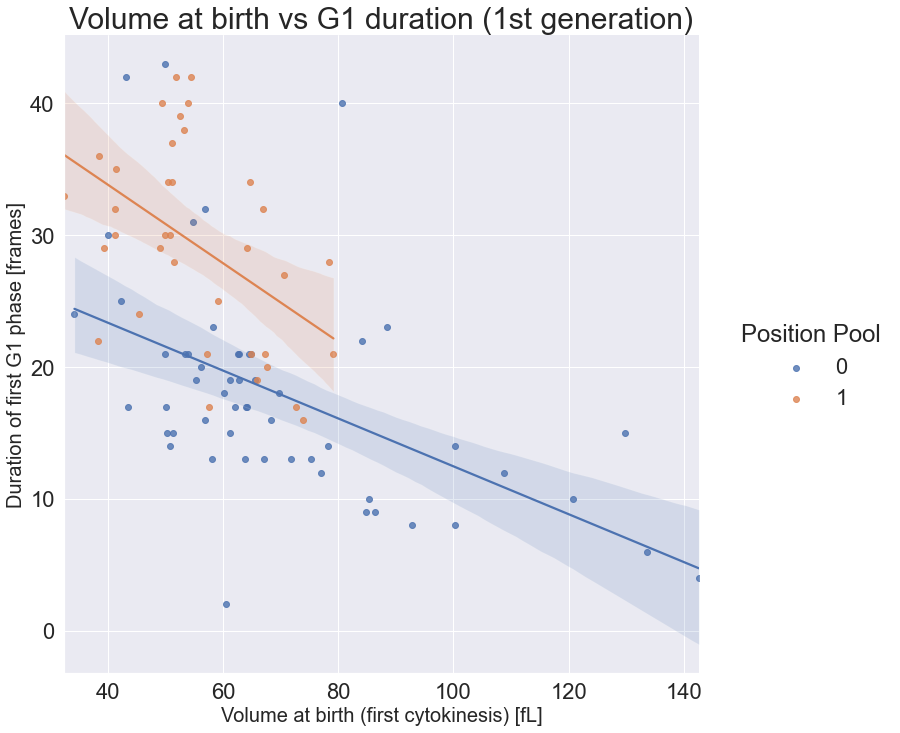

In [23]:
sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="volume_at_beginning", y="phase_length", data=plot_data3,
    hue="selection_subset", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("Duration of first G1 phase [frames]", fontsize=20)
ax.set_xlabel("Volume at birth (first cytokinesis) [fL]", fontsize=20)
ax.set_title("Volume at birth vs G1 duration (1st generation)", fontsize=30)
plt.show()

## Area and Volume at birth vs. mCitrine amount at birth (1st generation)

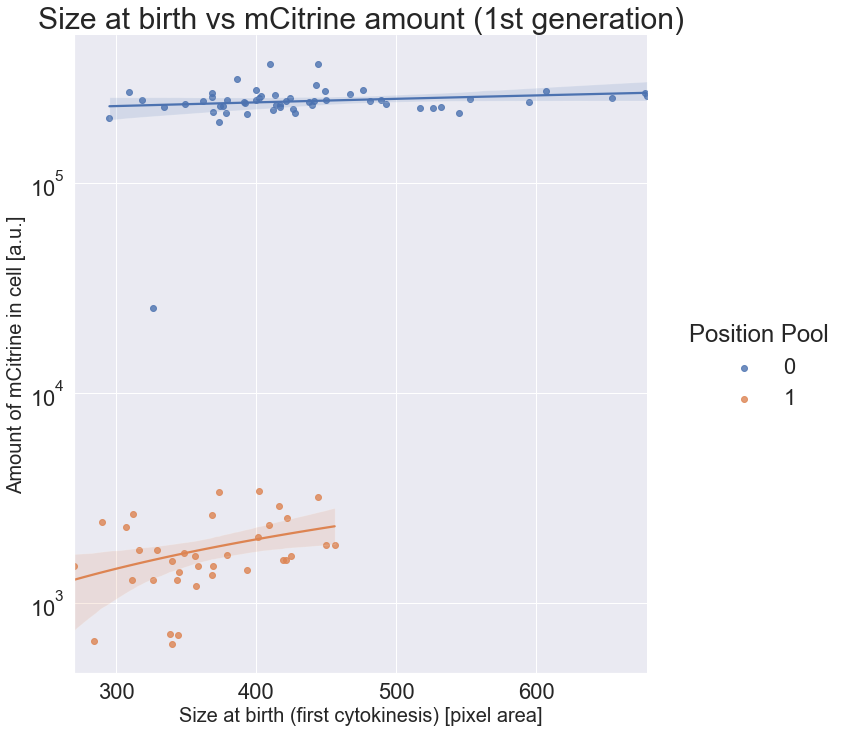

In [24]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
plot_data4 = phase_grouped[phase_grouped.cell_cycle_stage=="G1"]
plot_data4 = plot_data4[plot_data4.incomplete_phase==0]
plot_data4 = plot_data4[plot_data4.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="area_at_beginning", y="mCitrine_at_beginning", data=plot_data4,
    hue="selection_subset", height=10, )
g._legend.set_title('Position Pool')
g.set(yscale="log")
ax = plt.gca()
ax.set_ylabel("Amount of mCitrine in cell [a.u.]", fontsize=20)
ax.set_xlabel("Size at birth (first cytokinesis) [pixel area]", fontsize=20)
ax.set_title("Size at birth vs mCitrine amount (1st generation)", fontsize=30)
plt.show()

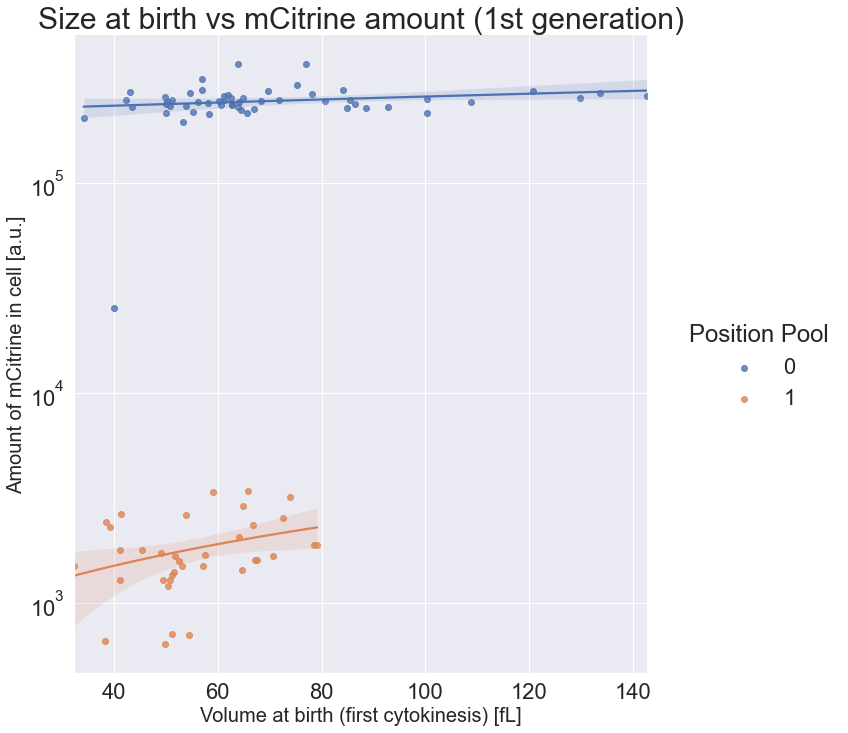

In [25]:
sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="volume_at_beginning", y="mCitrine_at_beginning", data=plot_data4,
    hue="selection_subset", height=10, )
g._legend.set_title('Position Pool')
g.set(yscale="log")
ax = plt.gca()
ax.set_ylabel("Amount of mCitrine in cell [a.u.]", fontsize=20)
ax.set_xlabel("Volume at birth (first cytokinesis) [fL]", fontsize=20)
ax.set_title("Size at birth vs mCitrine amount (1st generation)", fontsize=30)
plt.show()

## Area and Volume at birth vs. mCitrine concentration at birth (1st generation)

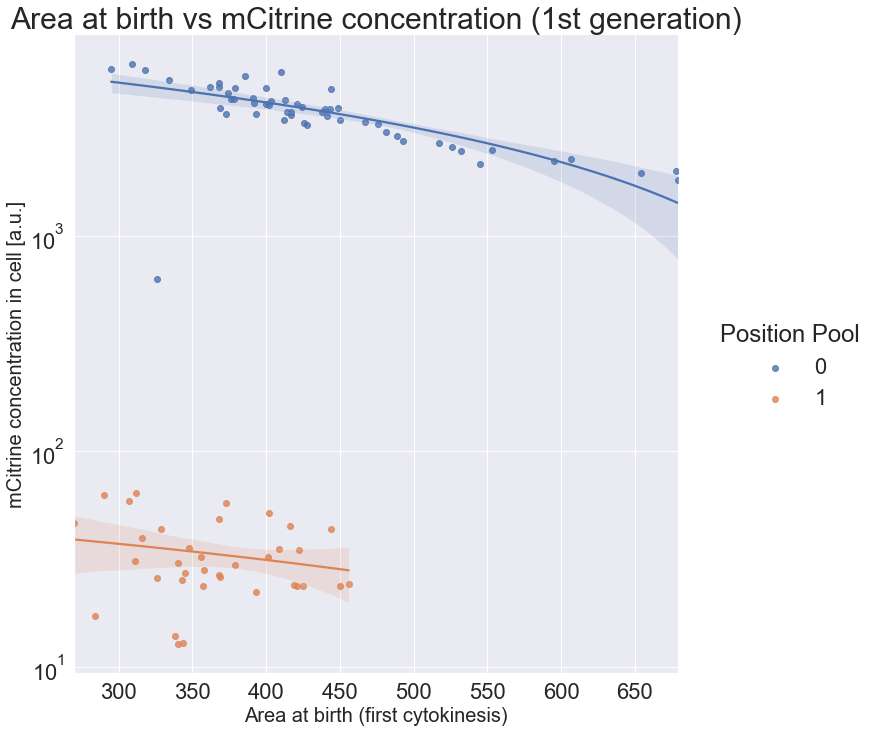

In [29]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
plot_data4 = phase_grouped[phase_grouped.cell_cycle_stage=="G1"]
plot_data4 = plot_data4[plot_data4.incomplete_phase==0]
plot_data4 = plot_data4[plot_data4.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="area_at_beginning", y="mCitrine_concentration_at_beginning", data=plot_data4,
    hue="selection_subset", height=10, )
g._legend.set_title('Position Pool')
g.set(yscale="log")
ax = plt.gca()
ax.set_ylabel("mCitrine concentration in cell [a.u.]", fontsize=20)
ax.set_xlabel("Area at birth (first cytokinesis)", fontsize=20)
ax.set_title("Area at birth vs mCitrine concentration (1st generation)", fontsize=30)
plt.show()

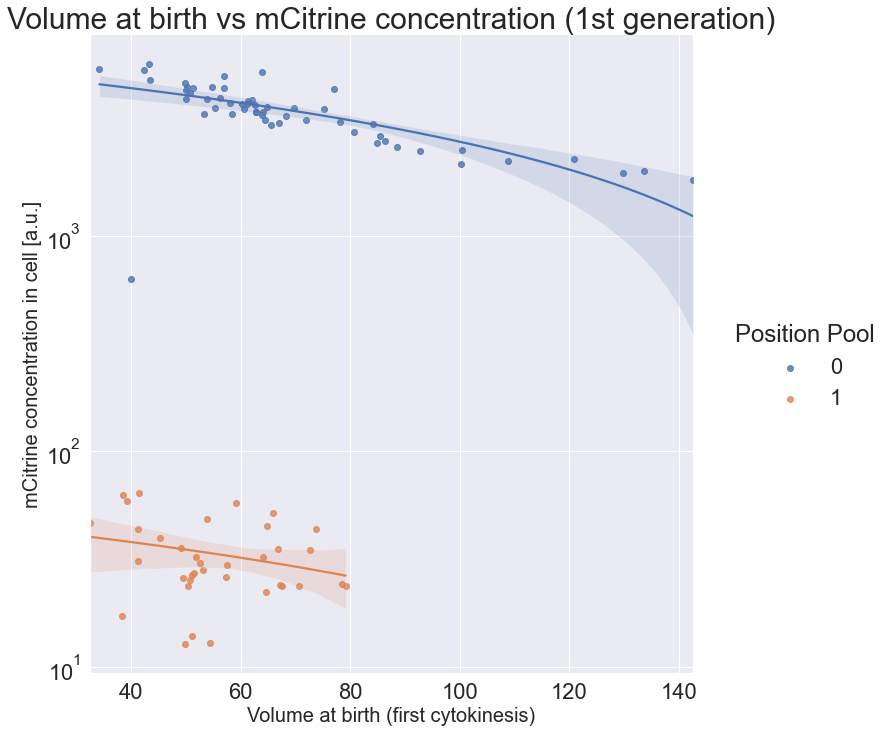

In [51]:
sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="volume_at_beginning", y="mCitrine_concentration_at_beginning", data=plot_data4,
    hue="selection_subset", height=10, )
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_yscale("log")
ax.set_ylabel("mCitrine concentration in cell [a.u.]", fontsize=20)
ax.set_xlabel("Volume at birth (first cytokinesis)", fontsize=20)
ax.set_title("Volume at birth vs mCitrine concentration (1st generation)", fontsize=30)
plt.show()

## Flurescence Signal over time (centered on bud emergence)

In [54]:
# select needed cols from overall_df to not end up with too many columns
needed_cols = [
    'selection_subset', 'position', 'Cell_ID', 'cell_cycle_stage', 'generation_num', 'frame_i',
    'mCitrine_corrected_mean', 'mCitrine_corrected_amount', 'mCitrine_corrected_concentration', 
    'file', 'relationship', 'relative_ID'
]
ov_copy = overall_df[needed_cols].copy()
# merge cells with their relatives to calculate combined amounts of mCitrine
merged = ov_copy.merge(
    ov_copy, 
    how='inner',
    left_on=['frame_i', 'file', 'position', 'relative_ID'],
    right_on=['frame_i', 'file', 'position', 'Cell_ID']
)
# calculate the length of the current phase for every line in the dataframe
phase_lengths = merged.groupby(
    ['Cell_ID_x', 'generation_num_x', 'cell_cycle_stage_x', 'position', 'selection_subset_x']
).agg(phase_length=('frame_i', lambda x: max(x)-min(x)+1)).reset_index()
merged = merged.merge(
    phase_lengths, 
    on=['Cell_ID_x', 'generation_num_x', 'cell_cycle_stage_x', 'position', 'selection_subset_x'],
    how='left'
)
# calculate the time the cell already spent in the current frame at the current timepoint
merged['frames_in_phase'] = merged.sort_values(['frame_i'], ascending=True)\
             .groupby(['Cell_ID_x', 'generation_num_x', 'cell_cycle_stage_x', 'position',
                       'file', 'selection_subset_x']).cumcount() + 1
# calculate the time to the next (for G1 cells) and from the last (for S cells) G1/S transition  
merged['centered_frames_in_phase'] = merged.apply(
    lambda x: x.loc['frames_in_phase'] if\
    x.loc['cell_cycle_stage_x']=='S' else\
    x.loc['frames_in_phase']-x.loc['phase_length'],
    axis=1
)
# calculate combined signal and the "Pool, Phase ID" for the legend
merged['combined_signal'] = merged.apply(
    lambda x: x.loc['mCitrine_corrected_amount_x']+x.loc['mCitrine_corrected_amount_y'] if\
    x.loc['cell_cycle_stage_x']=='S' and x.loc['relationship_x'] == 'mother' else\
    x.loc['mCitrine_corrected_amount_x'],
    axis=1
)
merged['bud_signal'] = merged.apply(
    lambda x: x.loc['mCitrine_corrected_amount_y'] if\
    x.loc['cell_cycle_stage_x']=='S' and x.loc['relationship_x'] == 'mother' else 0,
    axis=1
)
plot_data6 = merged[merged.relationship_x=='mother'].copy()
plot_data6['Pool, Phase'] = plot_data6.apply(
    lambda x: f'Pool {str(x.loc["selection_subset_x"])}, Phase {x.loc["cell_cycle_stage_x"]}', axis=1
)

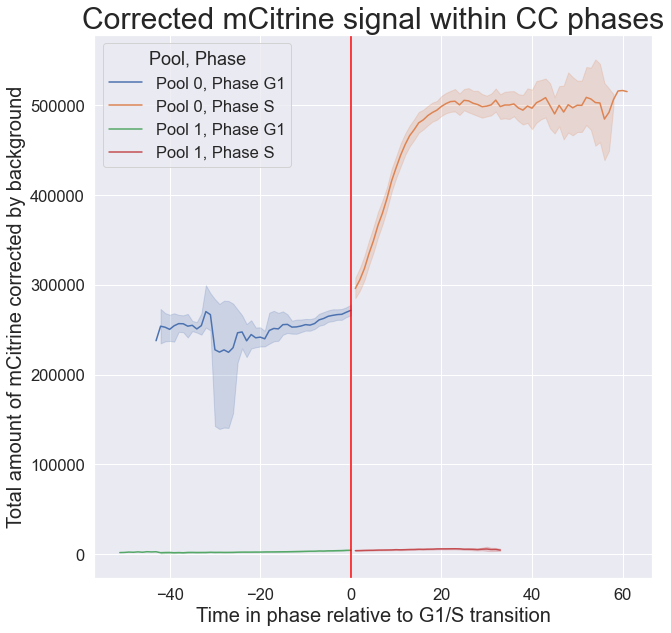

In [53]:
# plot the data
sns.set_theme(style="darkgrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(data=plot_data6.sort_values('Pool, Phase'), x="centered_frames_in_phase", y="combined_signal", 
             hue='Pool, Phase')
ax.axvline(x=0, color='red')
ax.set_ylabel("Total amount of mCitrine corrected by background", fontsize=20)
ax.set_xlabel("Time in phase relative to G1/S transition", fontsize=20)
ax.set_title("Corrected mCitrine signal within CC phases", fontsize=30)
plt.show()

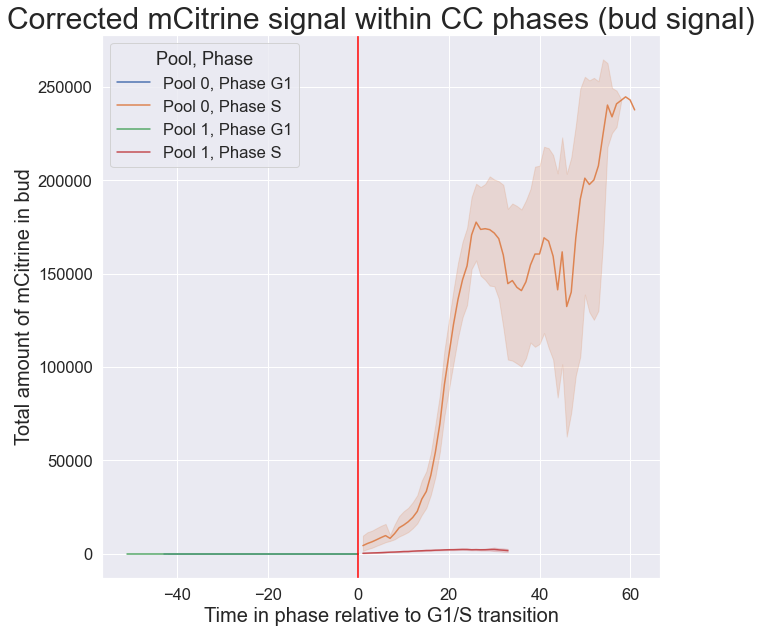

In [56]:
# plot the data
sns.set_theme(style="darkgrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(data=plot_data6.sort_values('Pool, Phase'), x="centered_frames_in_phase", y="bud_signal", 
             hue='Pool, Phase')
ax.axvline(x=0, color='red')
ax.set_ylabel("Total amount of mCitrine in bud", fontsize=20)
ax.set_xlabel("Time in phase relative to G1/S transition", fontsize=20)
ax.set_title("Corrected mCitrine signal within CC phases (bud signal)", fontsize=30)
plt.show()

## G1 vs. S duration (1st generation)

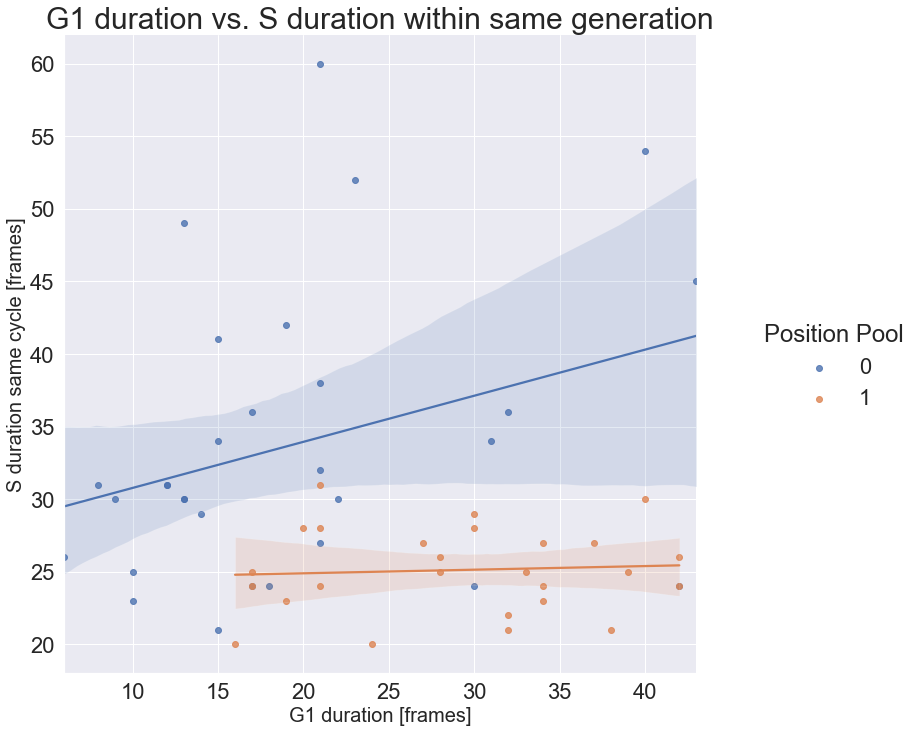

In [31]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
complete_cc_data = phase_grouped[phase_grouped.all_complete==1]
s_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="S"]
g1_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="G1"]
plot_data1 = g1_data.merge(s_data, on=['Cell_ID', 'generation_num', 'position', 'file'], how='inner')
plot_data1 = plot_data1[plot_data1.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="phase_length_x", y="phase_length_y", data=plot_data1,
    hue="selection_subset_x", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("S duration same cycle [frames]", fontsize=20)
ax.set_xlabel("G1 duration [frames]", fontsize=20)
ax.set_title("G1 duration vs. S duration within same generation", fontsize=30)
plt.show()

# backup

## Flurescence Signal vs. relative time in phase

In [164]:
needed_cols = [
    'selection_subset', 'position', 'Cell_ID', 'cell_cycle_stage', 'generation_num', 'frame_i',
    'mCitrine_corrected_mean_signal', 'mCitrine_corrected_signal_amount', 'file', 'relationship'
]
plot_data5 = overall_df[needed_cols].copy()
plot_data5['frames_in_phase'] = plot_data5.sort_values(['frame_i'], ascending=True)\
             .groupby(['Cell_ID', 'generation_num', 'cell_cycle_stage', 'position', 'file', 'selection_subset'])\
             .cumcount() + 1

phase_lengths = plot_data5.groupby(
    ['Cell_ID', 'generation_num', 'cell_cycle_stage', 'position', 'selection_subset']
).agg(phase_length=('frame_i', lambda x: max(x)-min(x)+1)).reset_index()
plot_data5 = plot_data5.merge(
    phase_lengths, 
    on=['Cell_ID', 'generation_num', 'cell_cycle_stage', 'position', 'selection_subset'],
    how='left'
)
plot_data5['relative_time_in_phase'] = plot_data5['frames_in_phase']/plot_data5['phase_length']
plot_data5['Pool, Phase, Type'] = plot_data5.apply(
    lambda x: f'Pool {str(x.loc["selection_subset"])}, Phase {x.loc["cell_cycle_stage"]}, Type {x.loc["relationship"]}', axis=1
)

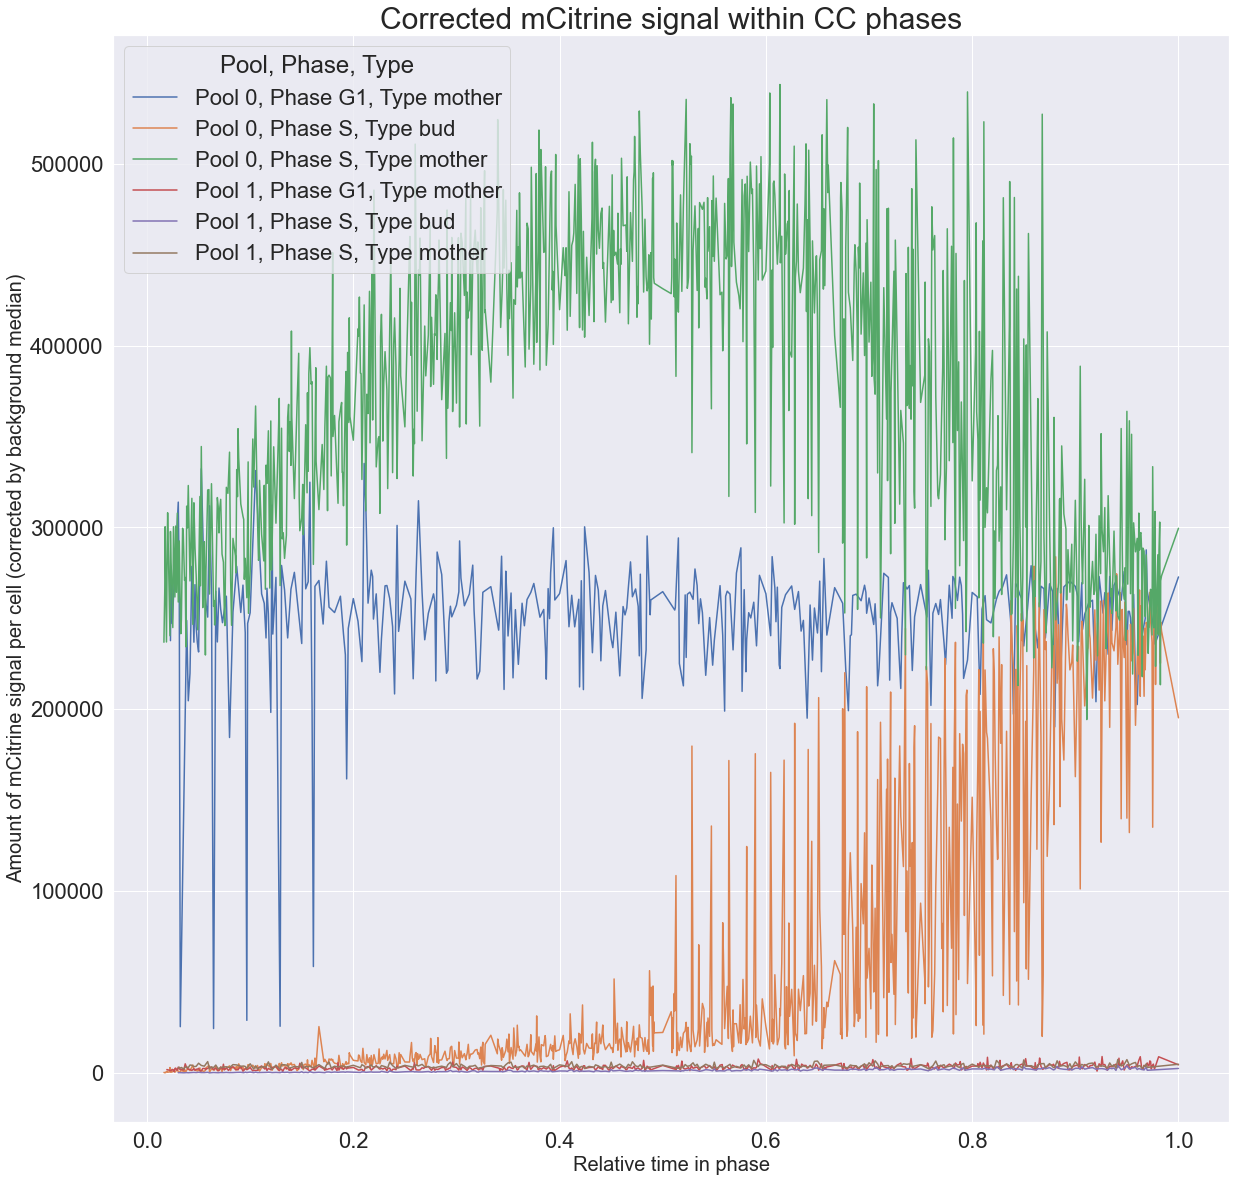

In [165]:
sns.set_theme(style="darkgrid", font_scale=2)
f, ax = plt.subplots(figsize=(20, 20))
sns.lineplot(data=plot_data5.sort_values('Pool, Phase, Type'), x="relative_time_in_phase", y="mCitrine_corrected_signal_amount", 
             hue='Pool, Phase, Type', ci=None)
ax.set_ylabel("Amount of mCitrine signal per cell (corrected by background median)", fontsize=20)
ax.set_xlabel("Relative time in phase", fontsize=20)
ax.set_title("Corrected mCitrine signal within CC phases", fontsize=30)
plt.show()

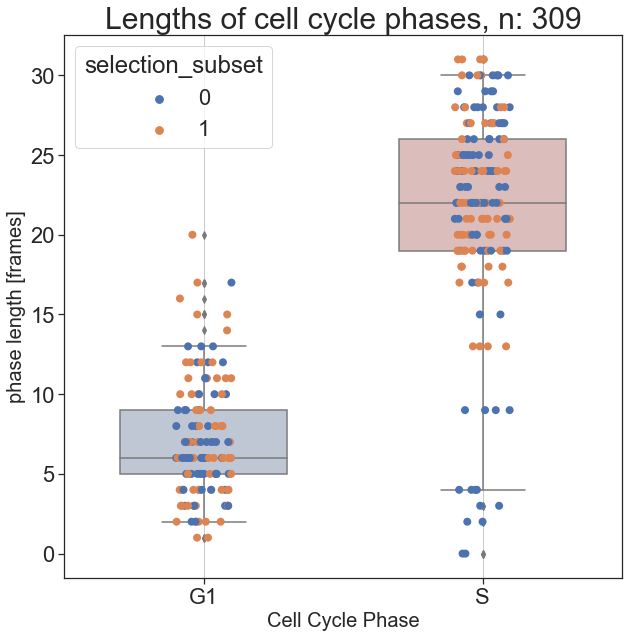

In [69]:
plot_data1 = phase_grouped[~incomplete_phase_indices]
sns.set_theme(style="ticks", font_scale=2)

# Initialize the figure
f, ax = plt.subplots(figsize=(10, 10))
# Plot the orbital period with horizontal boxes
sns.boxplot(x="cell_cycle_stage", y="phase_length", data=plot_data1,
            whis=[5, 95], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x="cell_cycle_stage", y="phase_length", data=plot_data1,
              size=8, hue="selection_subset", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set_ylabel("phase length [frames]", fontsize=20)
ax.set_xlabel("Cell Cycle Phase", fontsize=20)
ax.set_title(f"Lengths of cell cycle phases, n: {plot_data1.shape[0]}", fontsize=30)
#sns.despine(trim=True, left=True)
plt.show()

In [144]:
# code for calculating column "phase transition (boolean)"
"""
plot_data3['cell_pos_id'] = plot_data3.apply(lambda x: str(x.loc['Cell_ID'])+'-'+str(x.loc['position']), axis=1)

plot_data3['phase_transition'] = 0
for i in plot_data3.cell_pos_id.unique():
    sc_data = plot_data3.loc[plot_data3.cell_pos_id==i]
    phase_transition_indices = sc_data['cell_cycle_stage'] != sc_data['cell_cycle_stage'].shift(1)
    sc_data.loc[phase_transition_indices, 'phase_transition'] = 1
    plot_data3.loc[plot_data3.cell_pos_id==i] = sc_data
"""

"\nplot_data3['cell_pos_id'] = plot_data3.apply(lambda x: str(x.loc['Cell_ID'])+'-'+str(x.loc['position']), axis=1)\n\nplot_data3['phase_transition'] = 0\nfor i in plot_data3.cell_pos_id.unique():\n    sc_data = plot_data3.loc[plot_data3.cell_pos_id==i]\n    phase_transition_indices = sc_data['cell_cycle_stage'] != sc_data['cell_cycle_stage'].shift(1)\n    sc_data.loc[phase_transition_indices, 'phase_transition'] = 1\n    plot_data3.loc[plot_data3.cell_pos_id==i] = sc_data\n"

### alternatively configure stuff manually

In [24]:
# the path to the data folder containing the MIA_ folders
data_dir = os.path.join('..', 'data', 'nd2_files')
# the MIA_ folder which should be analyzed
mia_dir = 'MIA_F016.nd2'
# the positions which should be incorporated in the analysis
positions = [6]
# channels to incorporate in the Analysis, assuming to be the same for all positions
channels = ['phase_contr', 'mCitrine']